In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, LSTM

In [73]:
# load the data into a pandas dataframe
#df = pd.read_csv('EUR_USD Historical Data.csv')
df = pd.read_csv('EUR_USD Historical Data.csv', index_col='Date', parse_dates=True)

# select the 'Price' column as the target variable
target_col = 'Price'

# scale the data
scaler = MinMaxScaler()
df[target_col] = scaler.fit_transform(df[target_col].values.reshape(-1,1))

# create the training and testing datasets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# define the number of time steps and features
n_steps = 10
n_features = 1

# convert the data into sequences
def create_sequences(data, n_steps, n_features):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    X = np.array(X)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    y = np.array(y)
    return X, y

X_train, y_train = create_sequences(train_data[target_col].values.ravel(), n_steps, n_features)
X_test, y_test = create_sequences(test_data[target_col].values.ravel(), n_steps, n_features)



In [47]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-03-01,1.0665,1.0576,1.0692,1.0565,73.19K,0.84%
2023-02-28,1.0576,1.0605,1.0646,1.0574,86.73K,-0.29%
2023-02-27,1.0607,1.0541,1.0620,1.0532,84.55K,0.58%
2023-02-24,1.0546,1.0597,1.0616,1.0536,65.87K,-0.46%
2023-02-23,1.0595,1.0603,1.0628,1.0576,67.06K,-0.06%


In [74]:
# define the model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# make predictions for the next 5 days
last_n_steps = df[target_col].values[-n_steps:].reshape((1, n_steps, n_features))
next_n_days = []
for i in range(5):
    next_day = model.predict(last_n_steps)[0][0]
    next_n_days.append(next_day)
    last_n_steps = np.append(last_n_steps[:,1:,:], np.reshape([[next_day]], (1, 1, 1)), axis=1)

# invert the scaling
next_n_days = scaler.inverse_transform(np.array(next_n_days).reshape(-1,1)).flatten()



Epoch 1/100
14/14 [==============================] - 6s 97ms/step - loss: 0.0770 - val_loss: 0.0453
Epoch 2/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0187 - val_loss: 0.0017
Epoch 3/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0112 - val_loss: 0.0019
Epoch 4/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 5/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0085 - val_loss: 0.0016
Epoch 6/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 7/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0075 - val_loss: 0.0021
Epoch 8/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0089 - val_loss: 0.0024
Epoch 9/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0075 - val_loss: 0.0012
Epoch 10/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0069 - val_loss: 0.0012

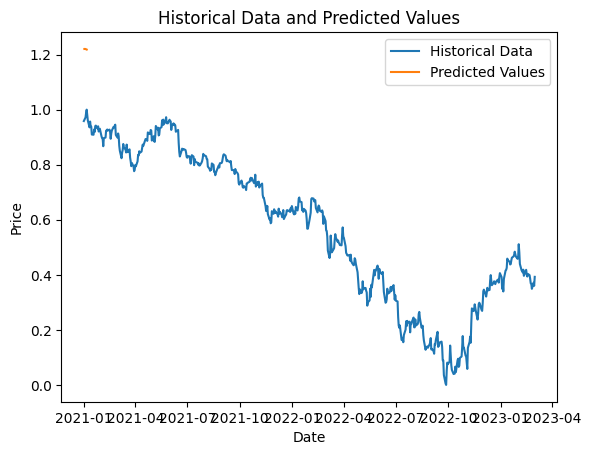

In [75]:
import matplotlib.pyplot as plt

# plot the historical data
plt.plot(df.index, df[target_col], label='Historical Data')

# create an index for the predicted values
pred_index = pd.date_range(start=df.index[-1], periods=5+1, freq='D')[1:]

# plot the predicted values
plt.plot(pred_index, next_n_days, label='Predicted Values')

# set the x-axis label
plt.xlabel('Date')

# set the y-axis label
plt.ylabel('Price')

# add a title to the plot
plt.title('Historical Data and Predicted Values')

# add a legend to the plot
plt.legend()

# show the plot
plt.show()


In [76]:
# create a list of dates for the next 5 days
dates = pd.date_range(df.index[-1], periods=5, freq='D').strftime('%Y-%m-%d').tolist()

# create a DataFrame with the predicted values and dates as the index
predictions_df = pd.DataFrame({'Date': dates, 'Predicted Price': next_n_days}).set_index('Date')

# print the DataFrame
print(predictions_df)


            Predicted Price
Date                       
2021-01-01         1.220515
2021-01-02         1.220654
2021-01-03         1.220172
2021-01-04         1.219308
2021-01-05         1.218372


In [65]:
# create a list of dates for the next 5 days
dates = pd.date_range(df.index[-1], periods=5, freq='D').strftime('%Y-%m-%d').tolist()

# create a DataFrame with the predicted values and dates as the index
predictions_df = pd.DataFrame({'Date': dates, 'Predicted Price': next_n_days}).set_index('Date')

# print the DataFrame
print(predictions_df)


            Predicted Price
Date                       
2021-01-01         1.277132
2021-01-02         1.276824
2021-01-03         1.275559
2021-01-04         1.273612
2021-01-05         1.271002
